In [ ]:
import numpy as np
import pandas as pd
import os
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2

In [ ]:
train_dataset_path = Path("/content/drive/MyDrive/Colab Notebooks/Capstone 1/Part 1/Images/Train")
test_dataset_path = Path("/content/drive/MyDrive/Colab Notebooks/Capstone 1/Part 1/Images/Test")
labels = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Capstone 1/Part 1/labels2.csv")

# Define target size
target_width = 720
target_height = 480

# Function to check images in a given directory
def check_image_sizes(directory):
    oversized_images = []
    for file_name in os.listdir(directory):
        if file_name.endswith(('.jpg', '.png', '.jpeg')):  # Add other formats if needed
            file_path = os.path.join(directory, file_name)
            image = cv2.imread(file_path)

            # Check if the image was loaded successfully
            if image is None:
                print(f"Could not read image: {file_path}")
                continue

            height, width = image.shape[:2]
            if width > target_width or height > target_height:
                oversized_images.append((file_name, width, height))

    return oversized_images

# Check train and test datasets
# oversized_train = check_image_sizes(train_dataset_path)
# oversized_test = check_image_sizes(test_dataset_path)

# print(f"Oversized images in train dataset: {oversized_train}")
# print(f"Oversized images in test dataset: {oversized_test}")

In [ ]:
# Display the first few rows and general information to analyze the data
labels_info = labels.info()
labels_head = labels.head()

labels_info, labels_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17967 entries, 0 to 17966
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      17967 non-null  int64 
 1   vehicle_type  17967 non-null  object
 2   x1            17967 non-null  int64 
 3   y1            17967 non-null  int64 
 4   x2            17967 non-null  int64 
 5   y2            17967 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 842.3+ KB


(None,
    image_id       vehicle_type   x1  y1   x2   y2
 0         0       pickup_truck  213  34  255   50
 1         0                car  194  78  273  122
 2         0                car  155  27  183   35
 3         0  articulated_truck   43  25  109   55
 4         0                car  106  32  124   45)

In [ ]:
# Check for invalid bounding boxes where x2 <= x1 or y2 <= y1
invalid_boxes = labels[(labels['x2'] <= labels['x1']) | (labels['y2'] <= labels['y1'])]

# Inspect unique vehicle types to ensure they match the predefined class mapping
unique_vehicle_types = labels['vehicle_type'].unique()

# Count the number of entries per image_id
entries_per_image = labels['image_id'].value_counts()

# Check for duplicate rows in the dataset
duplicate_rows = labels[labels.duplicated()]

# Output results
invalid_boxes_count = invalid_boxes.shape[0]
unique_vehicle_types_list = list(unique_vehicle_types)
duplicate_rows_count = duplicate_rows.shape[0]
entries_per_image_summary = entries_per_image.describe()

invalid_boxes_count, unique_vehicle_types_list, duplicate_rows_count, entries_per_image_summary

(0,
 ['pickup_truck',
  'car',
  'articulated_truck',
  'bus',
  'motorized_vehicle',
  'work_van',
  'single_unit_truck',
  'pedestrian',
  'bicycle',
  'non-motorized_vehicle',
  'motorcycle'],
 0,
 count    5626.000000
 mean        3.193566
 std         2.951104
 min         1.000000
 25%         1.000000
 50%         2.000000
 75%         4.000000
 max        27.000000
 Name: count, dtype: float64)

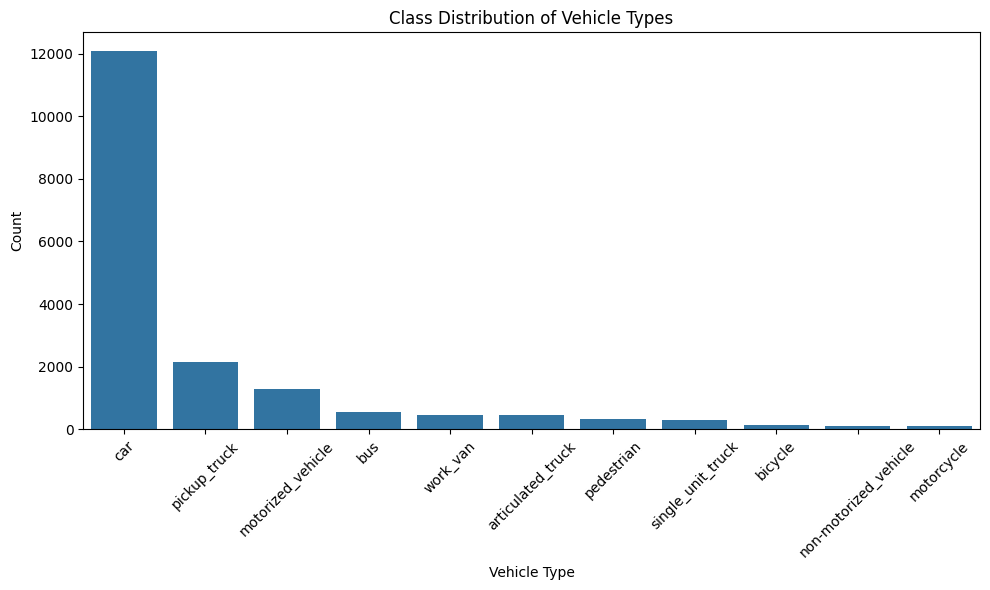

In [ ]:
# Calculate class distribution
class_distribution = labels['vehicle_type'].value_counts()

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution of Vehicle Types')
plt.xlabel('Vehicle Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Display unique vehicle type labels in the relevant column
unique_vehicle_types_new = labels.iloc[:, 1].unique()  # Assuming the second column contains vehicle types
#unique_vehicle_types_new

In [ ]:
# Separate training and testing labels based on image ID
train_labels = labels[labels.iloc[:, 0] <= 4000]
test_labels = labels[labels.iloc[:, 0] > 4000]

In [ ]:
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

train_labels, val_labels = train_test_split(train_labels, test_size=0.2, random_state=42)
# 80% train, 20% validation

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2)
])

class DataGenerator(Sequence):
    def __init__(self, image_ids, labels_df, dataset_path, batch_size=16, target_size=(480, 720), shuffle=False, augment=False):
        #target size should be height x width
        self.image_ids = image_ids
        self.labels_df = labels_df
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.target_size = target_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()
        self.class_mapping = {  'pickup_truck': 0,
                                'car': 1,
                                'articulated_truck': 2,
                                'bus': 3,
                                'motorized_vehicle': 4,
                                'work_van':5,
                                'single_unit_truck':6,
                                'pedestrian':7,
                                'bicycle':8,
                                'non-motorized_vehicle':9,
                                'motorcycle':10} #a class mapping dictionary

    def __len__(self):
        return len(self.image_ids) // self.batch_size

    def __getitem__(self, index):
        batch_ids = self.image_ids[index * self.batch_size:(index + 1) * self.batch_size]
        X, y_boxes, y_labels = self.__data_generation(batch_ids)
        return X, (y_boxes, y_labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_ids)

    def __data_generation(self, batch_ids):
        X = np.empty((self.batch_size, *self.target_size, 3))
        y_boxes = np.empty((self.batch_size, 4))  # Bounding box coordinates
        y_labels = np.empty((self.batch_size, 1))  # Vehicle type

        for i, img_id in enumerate(batch_ids):
            # Load and resize image
            img_path = os.path.join(self.dataset_path, f"{img_id:08}.jpg")

            # Check if the image file exists
            if not os.path.exists(img_path):
                print(f"Image file not found: {img_path}")
                # Handle missing image - assign default values or skip the sample
                X[i,] = np.zeros((*self.target_size, 3))  # Fill with zeros or a placeholder
                y_boxes[i,] = [0, 0, 0, 0]  # Or appropriate default values
                y_labels[i,] = -1  # Or appropriate default label
                continue  # Skip to the next image

            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Check if the image was loaded successfully
            if image is None:
                print(f"Failed to load image: {img_path}")
                # Handle loading failure - assign default values or skip the sample
                X[i,] = np.zeros((*self.target_size, 3))  # Fill with zeros or a placeholder
                y_boxes[i,] = [0, 0, 0, 0]  # Or appropriate default values
                y_labels[i,] = -1  # Or appropriate default label
                continue  # Skip to the next image

            # --- Check dimensions here ---
            img_height, img_width = image.shape[:2]
            if img_width > 720 or img_height > 480:
                print(f"Resizing image {img_id} with dimensions {img_width}x{img_height}")
                image = cv2.resize(image, self.target_size)  # Resize to target size first

            # Apply data augmentation if enabled
            if self.augment:
                image = tf.convert_to_tensor(image, dtype=tf.float32)

                img_height, img_width = image.shape[:2]
                pad_height = max(0, self.target_size[0] - img_height)
                pad_width = max(0, self.target_size[1] - img_width)

                # Apply padding only if necessary, converting to NumPy first
                if pad_height > 0 or pad_width > 0:
                    image = image.numpy()  # Convert to NumPy array
                    image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                else:
                    image = cv2.resize(image.numpy(), (self.target_size[1], self.target_size[0]))

                if img_height > self.target_size[0] or img_width > self.target_size[1]:
                    print(f"Image {img_id} exceeds target size: {img_width}x{img_height}")

                image = data_augmentation(image)  # Apply the augmentation pipeline
                image = np.array(image)  # Convert back to numpy format for consistency

                # Initialize pad_width and pad_height to 0 for augmentation case
                pad_width = 0
                pad_height = 0

            # Resize image to the target dimensions if not already done in aug
            else:
                #image = cv2.resize(image, self.dim)
                img_height, img_width = image.shape[:2]
                pad_height = max(0, self.target_size[0] - img_height)
                pad_width = max(0, self.target_size[1] - img_width)
                # Apply padding only if necessary
                if pad_height > 0 or pad_width > 0:
                    image = cv2.copyMakeBorder(image, 0, pad_height, 0, pad_width, cv2.BORDER_CONSTANT, value=[0, 0, 0])
                else:
                    image = cv2.resize(image, (self.target_size[1], self.target_size[0])) #resize takes width first then height
                # if img_height > self.target_size[0] or img_width > self.target_size[1]:
                #     print(f"Image {img_id} exceeds target size: {img_width}x{img_height}")

            # Normalize image
            X[i,] = image / 255.0

            # Get bounding box and class label
            label_row = self.labels_df[self.labels_df.iloc[:, 0] == img_id].values[0]

            x1, y1, x2, y2 = label_row[2:6]
            # x_min += pad_width // 2
            # x_max += pad_width // 2
            # y_min += pad_height // 2
            # y_max += pad_height // 2
            y_boxes[i,] = [x1, y1, x2, y2]

            y_boxes[i,] = [
                x1 / self.target_size[1],  # normalizing the bounding box coordinates
                y1 / self.target_size[0],  #
                x2 / self.target_size[1],  #
                y2 / self.target_size[0],  #
            ]

             # Convert vehicle type to numerical label using the class mapping
            vehicle_type = label_row[1]
            y_labels[i,] = self.class_mapping.get(vehicle_type, -1) # Get numerical label, use -1 for unknown types

        return X, y_boxes, y_labels

# Create datasets from generators with output_signature
def create_dataset(generator):
    output_signature = (
        tf.TensorSpec(shape=(16, 480, 720, 3), dtype=tf.float32),  # X (image data)
        (
            tf.TensorSpec(shape=(16, 4), dtype=tf.float32),  # y_boxes (bounding boxes)
            tf.TensorSpec(shape=(16, 1), dtype=tf.float32)   # y_labels (vehicle types)
        )
    )
    return tf.data.Dataset.from_generator(
        lambda: (generator[i] for i in range(len(generator))),
        output_signature=output_signature
    ).repeat(3)

# Initialize generators
train_generator = DataGenerator(train_labels.iloc[:, 0].values, train_labels, train_dataset_path, augment=False)
val_generator = DataGenerator(val_labels.iloc[:, 0].values, val_labels, train_dataset_path, augment=False)  # Validation generator
test_generator = DataGenerator(test_labels.iloc[:, 0].values, test_labels, test_dataset_path, augment=False)

# Create datasets
train_dataset = create_dataset(train_generator)
test_dataset = create_dataset(test_generator)
val_dataset = create_dataset(val_generator)  # Validation dataset

#train_dataset = train_dataset.batch(32, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = create_dataset(test_generator).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, models, Input
from sklearn.utils.class_weight import compute_class_weight

def create_object_detection_model(input_shape=(480, 720, 3), num_classes=11):
     # Input layer
    inputs = Input(shape=input_shape)

    # Feature extraction with added layers, and L2 regularization
    x = layers.Conv2D(32, (5, 5), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    #x = layers.Dropout(0.2)(x)  # Add spatial dropout
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    #x = layers.Dropout(0.4)(x)  # Add spatial dropout
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Bounding box regression head
    bbox_head = layers.Dense(128, activation='relu')(x)
    bbox_head = layers.Dense(64, activation='relu')(bbox_head)
    bbox_head = layers.Dense(32, activation='relu')(bbox_head)
    bbox_output = layers.Dense(4, activation='linear', name='bbox_output')(bbox_head)  # 4 values for the bounding box

    # Classification head
    class_head = layers.Dense(128, activation='relu')(x)
    class_head = layers.Dense(64, activation='relu')(class_head)
    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(class_head)  # num_classes is the number of vehicle types

    # Define model with two outputs
    model = models.Model(inputs=inputs, outputs=[bbox_output, class_output])
    return model

# def create_object_detection_model(input_shape, num_classes):
#     inputs = tf.keras.Input(shape=input_shape)
#     x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#     x = layers.MaxPooling2D((2, 2))(x)
#     x = layers.Conv2D(64, (3, 3), activation='relu')(x)
#     x = layers.Flatten()(x)
#     x = layers.Dense(64, activation='relu')(x)
#     bbox_head = layers.Dense(128, activation='relu')(x)
#     bbox_head = layers.Dense(64, activation='relu')(bbox_head)
#     bbox_output = layers.Dense(4, activation='linear', name='bbox_output')(bbox_head)  # 4 values for the bounding box
#     class_head = layers.Dense(128, activation='relu')(x)
#     class_head = layers.Dense(64, activation='relu')(class_head)
#     class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(class_head)  # num_classes is the number of vehicle types

#     model = tf.keras.Model(inputs=inputs, outputs=[class_output, bbox_output])
#     return model

# Initialize the model
model = create_object_detection_model(input_shape=(480, 720, 3), num_classes=11)
model.summary()

model.compile(
    optimizer='adam',
    #optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss={
        'bbox_output': 'mean_squared_error',  # or 'mean_absolute_error'
        'class_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'bbox_output': 'mse',
        'class_output': 'accuracy'
    }
)

batch_size=16
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005,
    decay_steps=int(np.ceil(len(train_labels)/batch_size))*3,
    decay_rate=0.98,
    staircase=True
)

# List of class labels
classes = labels['vehicle_type'].unique()
# Class mapping dictionary from the generator
class_mapping = {
    'pickup_truck': 0,
    'car': 1,
    'articulated_truck': 2,
    'bus': 3,
    'motorized_vehicle': 4,
    'work_van': 5,
    'single_unit_truck': 6,
    'pedestrian': 7,
    'bicycle': 8,
    'non-motorized_vehicle': 9,
    'motorcycle': 10
}

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(list(class_mapping.keys())),
    y=labels['vehicle_type']
)

# # Map to integer class indices
class_weights_dict = {class_mapping[class_label]: weight for class_label, weight in zip(class_mapping.keys(), class_weights)}

def weighted_sparse_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        # Map integer labels to their corresponding class weights
        weights = tf.gather(class_weights, tf.cast(y_true, tf.int32))
        # Compute standard sparse categorical crossentropy
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        # Apply weights
        return loss * tf.cast(tf.squeeze(weights), tf.float32)
    return loss

# Call weighted_sparse_categorical_crossentropy with class weights to create the loss function
weighted_loss = weighted_sparse_categorical_crossentropy(tf.constant(class_weights))

#SGD with weighted classes

# model.compile(
#     optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
#     loss={
#         'bbox_output': 'mean_squared_error',
#         'class_output': 'sparse_categorical_crossentropy'
#         #'class_output': weighted_loss
#     },
#     loss_weights={
#         'bbox_output': 0.50,  # Reduce weight for bbox loss
#         'class_output': 1.00  # Increase weight for classification loss
#     },
#     metrics={
#         'bbox_output': 'mse',
#         'class_output': 'accuracy'
#     }
# )

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 480, 720, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 476, 716, 32)   │          2,432 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 238, 358, 32)   │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 236, 356, 32)   │          9,248 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 118, 178, 32)   │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 116, 176, 64)   │         18,496 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 58, 88, 64)     │              0 │ conv2d_27[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 56, 86, 64)     │         36,928 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 28, 43, 64)     │              0 │ conv2d_28[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 26, 41, 128)    │         73,856 │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_28          │ (None, 13, 20, 128)    │              0 │ conv2d_29[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 11, 18, 128)    │        147,584 │ max_pooling2d_28[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 11, 18, 128)    │              0 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_29          │ (None, 5, 9, 128)      │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 5760)           │              0 │ max_pooling2d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │        737,408 │ flatten_3[0][0]        │
├──────────────────────

 Total params: 1,782,799 (6.80 MB)

 Trainable params: 1,782,799 (6.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for improvement
    patience=10,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)


# Number of epochs and batch size
epochs = 20
batch_size = 16
steps_per_epoch = int(np.ceil(len(train_labels) / batch_size)) #12528 labels => 195.something for 32 batch
validation_steps = int(np.ceil(len(test_labels) / batch_size)) #5440 labels => 85 for 32
#steps_per_epoch = 190 #based on above calc
#validation_steps = 80

# Train the model using the datasets
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    #class_weight=class_weights_dict, # CANNOT USE CLASS WEIGHTS SINCE THERE IS MORE THAN ONE OUTPUT :(
    #callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 243s 365ms/step - bbox_output_loss: 0.0800 - bbox_output_mse: 0.0800 - class_output_accuracy: 0.6804 - class_output_loss: 1.3019 - loss: 2.3162 - val_bbox_output_loss: 0.0570 - val_bbox_output_mse: 0.0570 - val_class_output_accuracy: 0.6752 - val_class_output_loss: 1.2564 - val_loss: 1.3740
Epoch 2/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 177s 283ms/step - bbox_output_loss: 0.0530 - bbox_output_mse: 0.0530 - class_output_accuracy: 0.6792 - class_output_loss: 1.2352 - loss: 1.3278 - val_bbox_output_loss: 0.0565 - val_bbox_output_mse: 0.0565 - val_class_output_accuracy: 0.6733 - val_class_output_loss: 1.2561 - val_loss: 1.3258
Epoch 3/20
  1/627 ━━━━━━━━━━━━━━━━━━━━ 1:46 169ms/step - bbox_output_loss: 0.0550 - bbox_output_mse: 0.0550 - class_output_accuracy: 0.8750 - class_output_loss: 0.8199 - loss: 0.8881

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


627/627 ━━━━━━━━━━━━━━━━━━━━ 229s 366ms/step - bbox_output_loss: 0.0522 - bbox_output_mse: 0.0522 - class_output_accuracy: 0.6787 - class_output_loss: 1.2298 - loss: 1.2914 - val_bbox_output_loss: 0.0566 - val_bbox_output_mse: 0.0566 - val_class_output_accuracy: 0.6752 - val_class_output_loss: 1.2540 - val_loss: 1.3159
Epoch 4/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 181s 288ms/step - bbox_output_loss: 0.0521 - bbox_output_mse: 0.0521 - class_output_accuracy: 0.6811 - class_output_loss: 1.2203 - loss: 1.2780 - val_bbox_output_loss: 0.0554 - val_bbox_output_mse: 0.0554 - val_class_output_accuracy: 0.6733 - val_class_output_loss: 1.2487 - val_loss: 1.3084
Epoch 5/20
627/627 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - bbox_output_loss: 0.0517 - bbox_output_mse: 0.0517 - class_output_accuracy: 0.6792 - class_output_loss: 1.2238 - loss: 1.2801 - val_bbox_output_loss: 0.0541 - val_bbox_output_mse: 0.0541 - val_class_output_accuracy: 0.6752 - val_class_output_loss: 1.2445 - val_loss: 1.3030
Epoch 6/20
 43/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Evaluate the model
test_loss, bbox_loss, class_loss, bbox_mse, class_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Bounding Box Loss: {bbox_loss}, Classification Loss: {class_loss}")
print(f"Bounding Box MSE: {bbox_mse}, Classification Accuracy: {class_acc}")

In [ ]:
import matplotlib.pyplot as plt

# Extract history
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Total Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot bounding box loss
plt.figure(figsize=(12, 6))
plt.plot(history_dict['bbox_output_loss'], label='Training BBox Loss')
plt.plot(history_dict['val_bbox_output_loss'], label='Validation BBox Loss')
plt.title('Bounding Box Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot classification accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_dict['class_output_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_class_output_accuracy'], label='Validation Accuracy')
plt.title('Classification Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Fetch a batch of test images
for X_test, (y_boxes_test, y_labels_test) in test_dataset.take(1):
    predictions = model.predict(X_test)
    pred_boxes, pred_classes = predictions

    for i in range(5):  # Visualize first 5 samples
        image = X_test[i].numpy()
        true_box = y_boxes_test[i].numpy()
        pred_box = pred_boxes[i]

        # Denormalize box coordinates if they were normalized
        true_box = [int(coord) for coord in true_box]
        pred_box = [int(coord) for coord in pred_box]

        # Draw ground truth and predicted boxes
        img_with_boxes = cv2.rectangle(image.copy(), (true_box[0], true_box[1]), (true_box[2], true_box[3]), (0, 255, 0), 2)  # True box in green
        img_with_boxes = cv2.rectangle(img_with_boxes, (pred_box[0], pred_box[1]), (pred_box[2], pred_box[3]), (255, 0, 0), 2)  # Predicted box in blue

        # Plot the image
        plt.figure(figsize=(6, 6))
        plt.imshow(img_with_boxes)
        plt.title(f"True Class: {y_labels_test[i]}, Pred Class: {np.argmax(pred_classes[i])}")
        plt.axis('off')
        plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true and predicted labels
true_labels = []
pred_labels = []

for X_test, (y_boxes_test, y_labels_test) in test_dataset.take(10):  # Adjust the number of batches to evaluate
    predictions = model.predict(X_test)
    _, pred_classes = predictions

    true_labels.extend(y_labels_test.numpy().flatten())
    pred_labels.extend(np.argmax(pred_classes, axis=1))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=list(train_generator.class_mapping.keys()))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


In [ ]:
def calculate_iou(box1, box2):
    # box = [x_min, y_min, x_max, y_max]
    x_min1, y_min1, x_max1, y_max1 = box1
    x_min2, y_min2, x_max2, y_max2 = box2

    # Calculate intersection
    x_min_inter = max(x_min1, x_min2)
    y_min_inter = max(y_min1, y_min2)
    x_max_inter = min(x_max1, x_max2)
    y_max_inter = min(y_max1, y_max2)

    intersection = max(0, x_max_inter - x_min_inter) * max(0, y_max_inter - y_min_inter)

    # Calculate union
    area1 = (x_max1 - x_min1) * (y_max1 - y_min1)
    area2 = (x_max2 - x_min2) * (y_max2 - y_min2)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0

# Evaluate IoU for a batch of test data
ious = []
for X_test, (y_boxes_test, y_labels_test) in test_dataset.take(10):  # Adjust number of batches
    predictions = model.predict(X_test)
    pred_boxes, _ = predictions

    for i in range(len(y_boxes_test)):
        true_box = y_boxes_test[i].numpy()
        pred_box = pred_boxes[i]

        iou = calculate_iou(true_box, pred_box)
        ious.append(iou)

# Analyze IoU
print(f"Mean IoU: {np.mean(ious):.2f}")
print(f"Median IoU: {np.median(ious):.2f}")

# Plot IoU distribution
plt.hist(ious, bins=20, alpha=0.7, color='blue')
plt.title("IoU Distribution")
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.show()


In [ ]:
for X_test, (y_boxes_test, y_labels_test) in test_dataset.take(1):
    predictions = model.predict(X_test)
    pred_boxes, pred_classes = predictions

    for i in range(len(y_labels_test)):
        true_label = y_labels_test[i].numpy().flatten()[0]
        pred_label = np.argmax(pred_classes[i])

        if true_label != pred_label:  # Misclassified example
            image = X_test[i].numpy()

            # Plot misclassified image
            plt.figure(figsize=(6, 6))
            plt.imshow(image)
            plt.title(f"True: {true_label}, Pred: {pred_label}")
            plt.axis('off')
            plt.show()
